In [1]:
# Default parameters
analysis_time = "2025-05-01T00:00:00Z"
model_name = "baseline_model"


# ML model comparison against Danish synop station observations

This notebook compares the performance of different machine learning models against observations from Danish synop stations. The observations are retrieved from the Danish Meteorological Institute (DMI) Open Data API.


In [31]:
import isodate
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import dmidc.metobs
import dmidc.harmonie
dmidc.__version__

'unknown'

In [3]:
# turn the analysis_time into a datetime object
analysis_time = isodate.parse_datetime(analysis_time)

## Loading station observations

In [4]:
forecast_duration = isodate.parse_duration("P1D")
obs_interval = slice(
    analysis_time, analysis_time + forecast_duration
)

In [5]:
# bbox for Denmark in WESN format
denmark_bbox = [
    8.0, 54.5, 15.0, 58.0
]  # West, South, East, North

In [ ]:
ds_obs = dmidc.metobs.load(observation_time=obs_interval, parameter=["temp_dry", "wind_speed"], bbox=denmark_bbox)
ds_obs = ds_obs.rename(dict(temp_dry="t2m"))
ds_obs

/Users/B280936/git-repos/dmi/dmi-mllam-verification-notebooks/src/dmidc/metobs/dmi_opendata/time_utils.py:45: UserWarning: timestamp has no timezone, assuming system timezone (CEST)
  warnings.warn(


<xarray.Dataset> Size: 30kB
Dimensions:     (station_id: 4, time: 288)
Coordinates:
  * station_id  (station_id) object 32B '06019' '06030' '06031' '06032'
  * time        (time) datetime64[ns] 2kB 2025-04-30T22:00:00 ... 2025-05-02T...
Data variables:
    t2m         (station_id, time) float64 9kB 9.4 9.4 9.4 9.3 ... 8.3 8.4 8.5
    wind_dir    (station_id, time) float64 9kB 231.0 231.0 239.0 ... 269.0 275.0
    wind_speed  (station_id, time) float64 9kB 3.3 2.6 3.0 3.2 ... 8.1 8.9 8.8

In [24]:
ds_stations = dmidc.metobs.get_stations(observation_time=obs_interval, bbox=denmark_bbox)

/Users/B280936/git-repos/dmi/dmi-mllam-verification-notebooks/src/dmidc/metobs/dmi_opendata/time_utils.py:45: UserWarning: timestamp has no timezone, assuming system timezone (CEST)
  warnings.warn(


In [37]:
ds_obs_with_station_info = xr.merge([ds_obs, ds_stations]).dropna(dim="station_id")
ds_obs_with_station_info

<xarray.Dataset> Size: 16kB
Dimensions:         (station_id: 2, time: 288)
Coordinates:
  * station_id      (station_id) object 16B '06030' '06031'
  * time            (time) datetime64[ns] 2kB 2025-04-30T22:00:00 ... 2025-05...
Data variables:
    t2m             (station_id, time) float64 5kB 10.4 9.4 9.9 ... 9.0 8.9 9.0
    wind_dir        (station_id, time) float64 5kB 184.0 194.0 ... 276.0 272.0
    wind_speed      (station_id, time) float64 5kB 3.1 3.6 3.6 ... 4.6 4.2 4.1
    station_name    (station_id) object 16B 'Flyvestation Ålborg' 'Tylstrup'
    lat             (station_id) float64 16B 57.1 57.19
    lon             (station_id) float64 16B 9.851 9.953
    station_height  (station_id) float64 16B 3.0 13.0

## Loading Harmonie DINI forecast data

In [7]:
# s3://harmonie-zarr/dini/control/2025-04-09T030000Z/
data_kind = "single_levels"
uri_dini = f"s3://harmonie-zarr/dini/control/{isodate.datetime_isoformat(analysis_time).replace(':', '')}/{data_kind}.zarr"
print(f"Loading model data from {uri_dini}")

ds_model = xr.open_zarr(uri_dini, consolidated=True)
ds_model

Loading model data from s3://harmonie-zarr/dini/control/2025-05-01T000000Z/single_levels.zarr


<xarray.Dataset> Size: 12GB
Dimensions:          (time: 37, y: 1606, x: 1906)
Coordinates:
    lat              (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
    level            int64 8B ...
    lon              (y, x) float64 24MB dask.array<chunksize=(1606, 1906), meta=np.ndarray>
  * time             (time) datetime64[ns] 296B 2025-05-01 ... 2025-05-02T12:...
  * x                (x) float64 15kB -1.528e+06 -1.526e+06 ... 2.282e+06
  * y                (y) float64 13kB -1.589e+06 -1.587e+06 ... 1.621e+06
Data variables: (12/14)
    cape_column      (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    dini_projection  float64 8B ...
    hcc              (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    lcc              (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    mcc              (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    mld              (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    ...               ...
    r2m              (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    t0m              (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    t2m              (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    u10m             (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    v10m             (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>
    vis              (time, y, x) float64 906MB dask.array<chunksize=(1, 1606, 1906), meta=np.ndarray>

In [17]:
ds_model.attrs["suite_name"] = "dini"
dmidc.harmonie.utils.sel_nearest_to_latlon_pt(ds=ds_model, pt=dict(lat=55.0, lon=10.0))

<xarray.Dataset> Size: 4kB
Dimensions:          (time: 37)
Coordinates:
    lat              float64 8B dask.array<chunksize=(), meta=np.ndarray>
    level            int64 8B ...
    lon              float64 8B dask.array<chunksize=(), meta=np.ndarray>
  * time             (time) datetime64[ns] 296B 2025-05-01 ... 2025-05-02T12:...
    x                float64 8B 1.134e+06
    y                float64 8B 9.332e+04
Data variables: (12/14)
    cape_column      (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    dini_projection  float64 8B ...
    hcc              (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    lcc              (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    mcc              (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    mld              (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    ...               ...
    r2m              (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    t0m              (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    t2m              (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    u10m             (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    v10m             (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
    vis              (time) float64 296B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    suite_name:  dini

In [ ]:
ds_model["wind_speed"] = np.sqrt(ds_model["u10m"]**2 + ds_model["v10m"]**2)
ds_model.wind_speed.attrs["units"] = "m/s"
ds_model["wind_speed"].attrs["long_name"] = "Wind speed at 10m"

# change t2m to celcius
assert ds_model["t2m"].attrs["units"] == "K"
ds_model["t2m"] = ds_model["t2m"] - 273.15
ds_model.t2m.attrs["units"] = "C"

KeyboardInterrupt: 

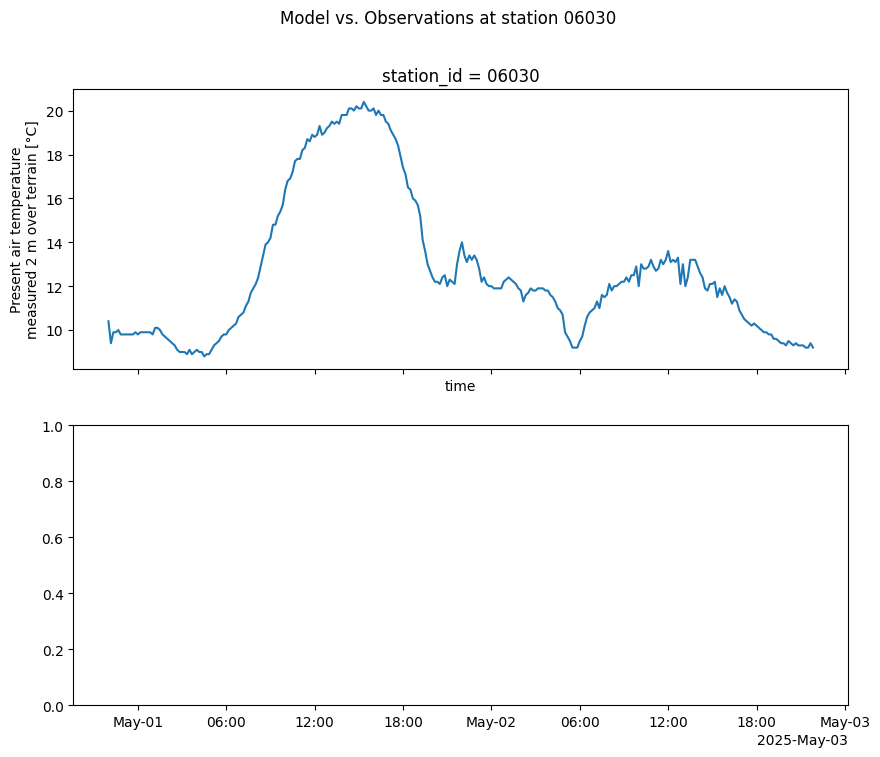

In [ ]:
params = ["t2m", "wind_speed"]

for station_id in ds_obs_with_station_info.station_id.values:
    station = ds_obs_with_station_info.sel(station_id=station_id)
    ds_model_at_station = dmidc.harmonie.utils.sel_nearest_to_latlon_pt(
        ds=ds_model,
        pt=dict(lat=station.lat.values, lon=station.lon.values)
    )
    
    fig, axes = plt.subplots(
        nrows=len(params), ncols=1, figsize=(10, 8), sharex=True
    )
    fig.suptitle(f"Model vs. Observations at station {station_id}")
    for i, param in enumerate(params):
        ax = axes[i]
        ds_obs_with_station_info[param].sel(station_id=station_id).plot(ax=ax, label="Observations")
        ds_model_at_station[param].plot(ax=ax, label="Model", marker=".")
        ax.set_title(param)
        ax.legend()
